# Global Setting

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import acovf
from sklearn.model_selection import TimeSeriesSplit
from prophet import Prophet
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_plotly
import xgboost as xgb
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import adfuller
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from pmdarima.arima import auto_arima
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

c:\Users\fcamargo\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### Load data

In [2]:
sales = pd.read_csv('../data/sales_products_ts.csv')
products_info = pd.read_csv("../data/products_statistics.csv")
holidays = pd.read_csv('../data/festivos.csv')

In [3]:
# sales = pd.read_csv('../data/historico_ventas.csv')
# sales = sales[sales['material'].isin(products_info['id'])]
# sales.rename(columns={'material':'id', 'fecha_semana':'date', 'cantidad':'quantity'}, inplace=True)

Define error functions

In [4]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

def wape(y_true, y_pred):
    acovf_vals = acovf(y_true, unbiased=False)
    return np.sum(np.abs(y_true - y_pred) / acovf_vals) * 100

# metric for interminent demand series
mase = MeanAbsoluteScaledError()



Define metrics dataframe

In [5]:
metrics = pd.DataFrame(columns=['id','model','rmse', 'mape', 'mase'])

Replace outliers function

In [6]:
def replace_outliers(df):
    q3 = np.quantile(df['quantity'], 0.75)
    q1 = np.quantile(df['quantity'], 0.25)
    iqr = np.subtract(*np.percentile(df['quantity'], [75, 25], interpolation='linear', axis=0))
    max_limit = q3 + (1.5 * iqr)
    min_limit = q1 - (1.5 * iqr)
    df.loc[df['quantity'] > max_limit, 'quantity'] = max_limit
    df.loc[df['quantity'] < min_limit, 'quantity'] = min_limit

    return df


Preprocessing data

In [7]:
def preprocessing(df):
    sorted = df.groupby('id').sum('quantity').sort_values('quantity', ascending=False)
    id_list = sorted.index.unique()
    df['date'] = pd.DatetimeIndex(df.date)
    df = df.sort_values('date')
    df = df.reset_index(drop=True)
    df.index = pd.PeriodIndex(df.date, freq='W')
    df['log'] = np.log1p(df.quantity)
    df = df[['id','date', 'quantity', 'log']]
    return df, id_list

Plot the time series

In [8]:
def initial_plots(df, item):
    fig, (a1,a2) = plt.subplots(1,2, figsize=(15, 5))
    a1.plot(df.date, df['quantity'])
    a1.set_title(f'Original Serie - {item}')
    a2.plot(df.date, df['log'], color='r')
    a2.set_title(f'Log Transformation - {item}')
    fig.tight_layout()
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig.savefig(f'../scale_outputs/{item}/images/ts_plot.png')
    plt.show()
    return fig

Train-test split

In [9]:
def split(df):
  weeks_train = round((max(df['date']) - min(df['date'])).days / 7 * 0.8)
  split_date = min(df['date']) + timedelta(weeks=weeks_train)
  train = df[df['date']< split_date] 
  test = df[df['date'] >= split_date]
  return split_date, train, test

Mean

In [10]:
def apply_mean_model(df, train, test, item):
    mean_model = train.log.mean()
    test['qtyMean'] = np.expm1(mean_model)
    df = df.merge(test[['qtyMean']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyMean'])
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/mean_model.png')
    row = {'id': item, 
         'model': 'mean', 
         'rmse': round(rmse(test.quantity,test.qtyMean)),  
         'mape': round(mape(test.quantity,test.qtyMean),2),  
         'mase': round(mase(test.quantity,test.qtyMean, y_train=train.quantity, sp=7),2)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, test

Linear model
* Time difference 

In [11]:
def apply_linear_model(df, train, test, item):
    train['timeIndex'] = train.date - train.date.min()
    train["timeIndex"] =  train["timeIndex"]/np.timedelta64(1, 'W')
    train["timeIndex"] = train["timeIndex"].round(0).astype(int)
    test['timeIndex'] = test.date - train.date.min() # verificar si se compara contra el date de train o test
    test["timeIndex"] =  test["timeIndex"]/np.timedelta64(1, 'W')
    test["timeIndex"] = test["timeIndex"].round(0).astype(int)
    model = smf.ols('log ~ timeIndex', data = train).fit()
    model_linear_pred = model.predict(test)
    test['qtyLinear'] = np.expm1(model_linear_pred)
    df = df.merge(test[['qtyLinear','timeIndex']], how= 'left', left_index=True, right_index=True)
    #plot = df.plot(kind="line", x="timeIndex", y = "qtyLinear")
    #plt.plot(df.timeIndex,model_linear_pred, '-')
#     os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
#     fig = plot.get_figure()
#     fig.savefig(f'../scale_outputs/{item}/images/linear_model.png')
    row = {'id': item, 
         'model': 'Linear model', 
         'rmse': round(rmse(test.quantity,test.qtyLinear)),  
         'mape': round(mape(test.quantity,test.qtyLinear),2),  
         'mase': round(mase(test.quantity,test.qtyLinear, y_train=train.quantity, sp=7),2)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, train, test

Random Walk

In [12]:
def apply_random_walk(df, train, test, item):
    train['lag'] = train.quantity.shift()
    #train.plot(kind= "scatter", y = "log", x = "lag_log", s = 50);
    test['qtyRW'] = train.lag.tail(n=1).values[0]
    df = df.merge(test[['qtyRW']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyRW'])
    os.makedirs(f'../scale_outputs/{item}/images/', exist_ok=True)
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/random_walk_model.png')
    row = {'id': item, 
         'model': 'Random Walk', 
         'rmse': round(rmse(test.quantity,test.qtyRW)),  
         'mape': round(mape(test.quantity,test.qtyRW),2),  
         'mase': round(mase(test.quantity,test.qtyRW, y_train=train.quantity, sp=7),2)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, train, test

Moving Average

In [13]:
def apply_moving_average(df, train, test, item):
    train['log_MA4'] = df.log.rolling(window = 4).mean()
    test['qtyMA4'] = np.expm1(train.log_MA4.tail(n=1).values[0])
    df = df.merge(test[['qtyMA4']], how= 'left', left_index=True, right_index=True)
#     plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyMA4'])
#     fig = plot.get_figure()
#     fig.savefig(f'../scale_outputs/{item}/images/moving_average.png')
    row = {'id': item, 
         'model': 'Moving average', 
         'rmse': round(rmse(test.quantity,test.qtyMA4)),  
         'mape': round(mape(test.quantity,test.qtyMA4),2),  
         'mase': round(mase(test.quantity,test.qtyMA4, y_train=train.quantity, sp=7),2)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, train, test
    

Arima

In [14]:
def apply_arima(df, train, test, item):
    ts_log = train.log
    model = auto_arima(ts_log,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )
    test['qtyArima'] = np.expm1(model.predict(n_periods =len(df.index)))
    df = df.merge(test[['qtyArima']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyArima'])
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/arima.png')
    row = {'id': item, 
         'model': 'Arima', 
         'rmse': round(rmse(test.quantity,test.qtyArima)),  
         'mape': round(mape(test.quantity,test.qtyArima),2),  
         'mase': round(mase(test.quantity,test.qtyArima, y_train=train.quantity, sp=7),2)
         }
    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

    return df, test

Prophet

$Y_t = g(t) + s(t) + h(t) + e_t$

* $g(t)$ growth term
* $s(t)$: seasonal patterns
* $h(t)$: holidays effects
* $e_t$: error term

In [15]:
def tuning_hyperparameters_prophet(df, train, test, item, split_date):
    new_df = pd.DataFrame({'ds': df.index.to_timestamp(),'y':df.log}).reset_index()
    new_df = new_df.drop('date', axis=1)
    param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    rmses = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        m = Prophet(**params, growth='flat') # flat is used to avoid errors
        m.add_country_holidays(country_name='ES')
        m.fit(new_df) 
        df_cv = cross_validation(m, initial='500 days', period='30 days', horizon='30 days', parallel="processes")
        df_p = performance_metrics(df_cv, rolling_window=1)
        rmses.append(df_p['rmse'].values[0])
        
    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['rmse'] = rmses
    #print(tuning_results)

    # Find the best parameters
    best_params = all_params[np.argmin(rmses)]
    return new_df, best_params

In [16]:
def apply_prophet(df, p_df, best_params, train, test, item, split_date):
    auto_model = Prophet(changepoint_prior_scale=best_params['changepoint_prior_scale'], 
                        seasonality_prior_scale=best_params['seasonality_prior_scale'], 
                        seasonality_mode=best_params['seasonality_mode'], growth='flat')
    # Add holidays
    auto_model.add_country_holidays(country_name='ES')
    # Fit the model
    auto_model.fit(p_df)
    # Cross validation
    days = (split_date - p_df.ds.min()).days
    days = str(days-30) + " days" # we substract 30 days to ensure test date period
    auto_model_cv = cross_validation(auto_model, initial=days, period='30 days', horizon = '30 days', parallel="processes")
    # Model performance metrics
    auto_model_cv_p = performance_metrics(auto_model_cv, rolling_window=1)
    # save results for test split (exponential transformation)
    auto_model_cv_test = auto_model_cv[auto_model_cv['ds'] >= split_date]
    auto_model_cv_test.index = pd.PeriodIndex(auto_model_cv_test.ds, freq='W')
    test['qtyProphet'] = np.expm1(auto_model_cv_test.yhat)
    df = df.merge(test[['qtyProphet']], how= 'left', left_index=True, right_index=True)
    plot = df.plot(kind="line", x="date", y = ["quantity", 'qtyProphet'])
    fig = plot.get_figure()
    fig.savefig(f'../scale_outputs/{item}/images/prophet.png')
    # save metrics
    row = {'id': item, 
         'model': 'Prophet', 
         'rmse': round(rmse(test.quantity,test.qtyProphet)),  
         'mape': round(mape(test.quantity,test.qtyProphet),2),  
         # revisar si se utiliza el df cv para el MASE
         'mase': round(mase(test.quantity,test.qtyProphet, y_train=train.quantity, sp=7),2) 
         }

    global metrics
    metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)
    
    return df, test

XGBoost

In [17]:
def xgb_initial_transformations(df):
    df = df.set_index('date')
    df.index = pd.to_datetime(df.index).normalize()
    df = df.sort_index()
    df['week'] = df.index.week
    df['mes'] = df.index.month

    return df

Cross Validation Ilustration:
* 5 Folds, test size of 1 quarter

In [18]:
def adv_xgb_split_cv(df):
    split_cv = TimeSeriesSplit(n_splits=5, test_size=4*3*1, gap=7) 
    fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)
    fold = 0
    for train_idx, val_idx in split_cv.split(df):
        train = df.iloc[train_idx]
        test = df.iloc[val_idx]
        train['quantity'].plot(ax=axs[fold],
                            label='Training Set',
                            title=f'Data Train/Test Split Fold {fold}')
        test['quantity'].plot(ax=axs[fold],
                            label='Test Set')
        axs[fold].axvline(test.index.min(), color='black', ls='--')
        fold += 1
    
    return fig, split_cv

Create Lag variable

In [19]:
def adv_xgb_create_lag(df):
    target_map = df['quantity'].to_dict()
    df['lag_year'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df[['quantity', 'lag_year']].tail()

    return df

Cross validation and hyperparameter tuning

In [20]:
def adv_xgb_cv_tuning(df, split_cv, item):
        fold= 0
        predictions_cv = []
        mape_scores_cv = [] 
        rmse_scores_cv = [] 
        mase_scores_cv = []
        for train_idx, val_idx in split_cv.split(df):
                train = df.iloc[train_idx]
                test = df.iloc[val_idx]
                
                FEATURES = ['mes','week', 'lag_year'] # add holidays
                TARGET = ['quantity']

                x_train = train[FEATURES]
                y_train = train[TARGET]

                x_test = test[FEATURES]
                y_test = test[TARGET]

                reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                                        n_estimators=1000,
                                        early_stopping_rounds=50,
                                        objective='reg:linear',
                                        max_depth=3,
                                        learning_rate=0.01)
                reg.fit(x_train, y_train,
                        eval_set=[(x_train, y_train), (x_test, y_test)],
                        verbose=100)

                y_pred = reg.predict(x_test)
                predictions_cv.append(y_pred)
                #score =  # RMSE formula
                mape_score = mape(y_test, y_pred)
                mape_scores_cv.append(mape_score)
                rmse_score = rmse(y_test, y_pred)
                rmse_scores_cv.append(rmse_score)
                mase_score = mase(y_test,y_pred, y_train=y_train, sp=7)
                mase_scores_cv.append(mase_score)
        row = {'id': item, 
         'model': 'XGBoost', 
         'rmse': round(np.mean(rmse_scores_cv)),  
         'mape': round(np.mean(mape_scores_cv),2),  
         'mase': round(np.mean(mase_scores_cv),2)
         }
        global metrics
        metrics = pd.concat([metrics, pd.DataFrame(row, index=[0])], ignore_index=True)

        return predictions_cv, rmse_scores_cv

Model

In [21]:
def adv_xgb_fitmodel(df):
    FEATURES = ['mes','week', 'lag_year'] 
    TARGET = ['quantity']

    x_all = df[FEATURES]
    y_all = df[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5,
                        booster='gbtree',    
                        n_estimators=500, # avoid overfitting
                        objective='reg:linear',
                        max_depth=3,
                        learning_rate=0.01)
    adv_xgb_model = reg.fit(x_all, y_all,
            eval_set=[(x_all, y_all)],
            verbose=100)
    
    return adv_xgb_model

Future importance

In [22]:
def xgb_future_importance(model):
    fi = pd.DataFrame(data= model.feature_importances_,
                    index=model.feature_names_in_,
                    columns=['importance'])
    plot_fi = fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
    return plot_fi

Function to appy XGBoost

In [23]:
def apply_adv_xgb(df):
    #df = df[df[variable] != 0]
    df = xgb_initial_transformations(df)
    plot_crossvalidation, split_cv = adv_xgb_split_cv(df)
    df = adv_xgb_create_lag(df)
    predictions_cv, scores_cv = adv_xgb_cv_tuning(df, split_cv, item)
    model = adv_xgb_fitmodel(df)
    plot_future_importance = xgb_future_importance(model)
    # # plot_test_evaluation = xgb_evaluation(df, test, model, predictors_test)
    # df_forecast, forecasting_plot = adv_xgb_forecasting(15, df, model)
    # return forecasting_plot
    #return df

In [24]:
#sales = sales[sales['quantity']!=0]
sales, id_list = preprocessing(sales)

Multiple time series loop

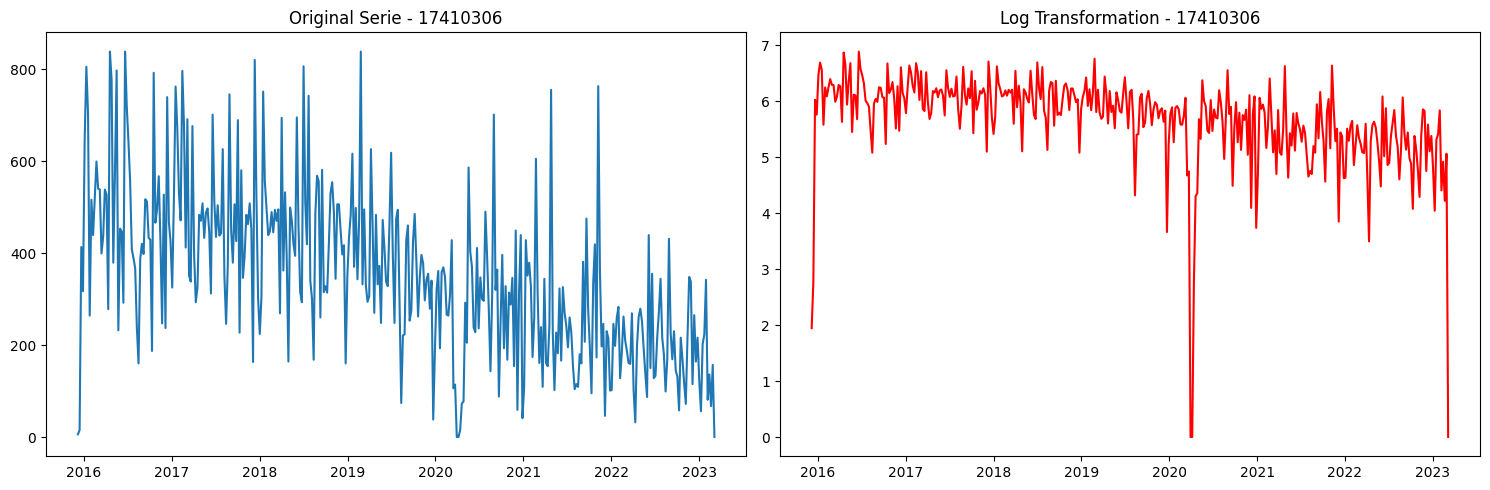

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=812.290, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=710.532, Time=0.13 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.80 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=799.697, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=691.098, Time=0.32 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=673.651, Time=0.63 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=665.707, Time=1.24 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=647.999, Time=2.60 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=641.281, Time=10.95 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=5.49 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=642.341, Time=10.91 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=5.11 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=659.683, Time=6.19 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=634.950, Time=12.34 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC

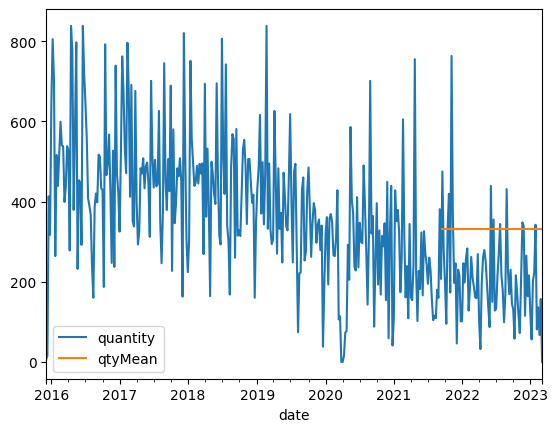

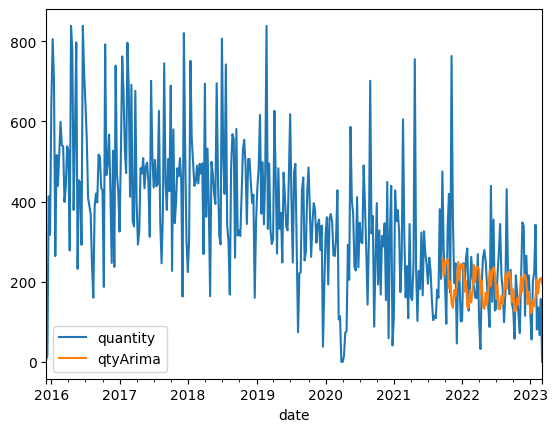

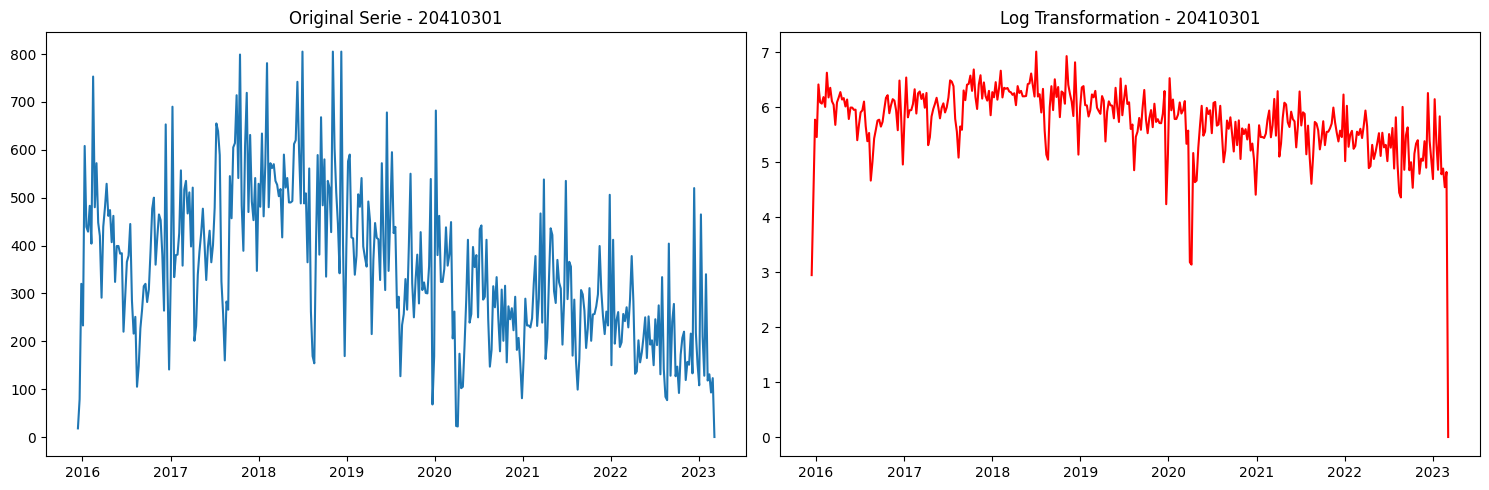

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=577.617, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=490.178, Time=0.21 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=561.180, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=455.669, Time=0.31 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=440.476, Time=0.56 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=431.961, Time=1.12 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=423.693, Time=2.57 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=19.46 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=8.73 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=442.248, Time=2.07 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=401.777, Time=3.85 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=411.012, Time=1.87 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=18.67 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf,

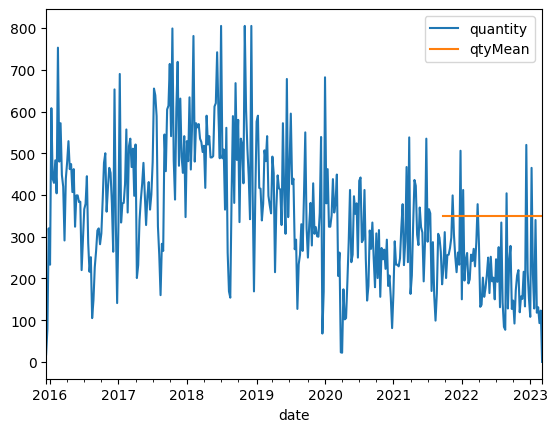

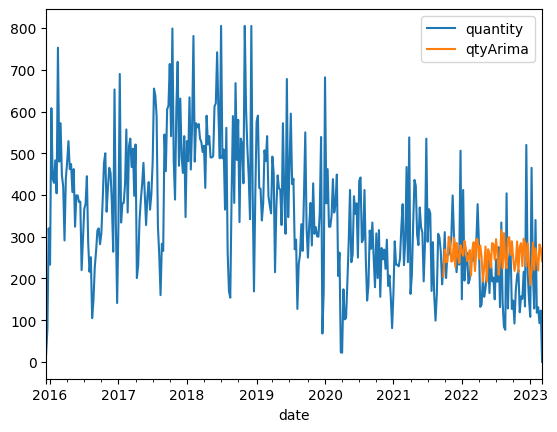

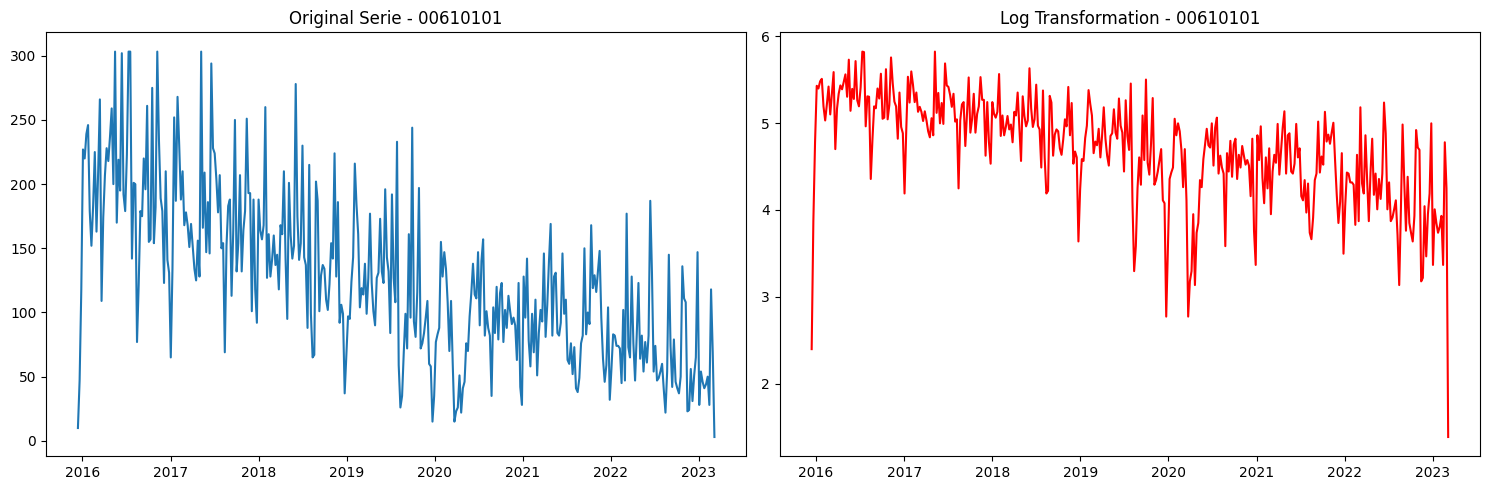

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=579.642, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=473.894, Time=0.11 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.81 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=543.457, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=415.137, Time=0.32 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=396.982, Time=0.84 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=388.860, Time=1.49 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=382.207, Time=6.20 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=22.94 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=8.09 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=414.537, Time=1.98 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=378.632, Time=2.83 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=385.999, Time=1.31 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=18.79 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf,

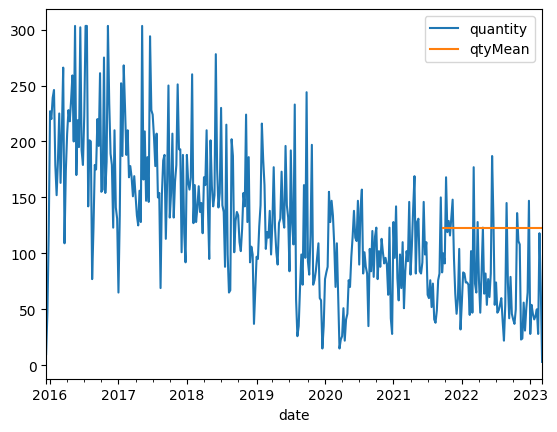

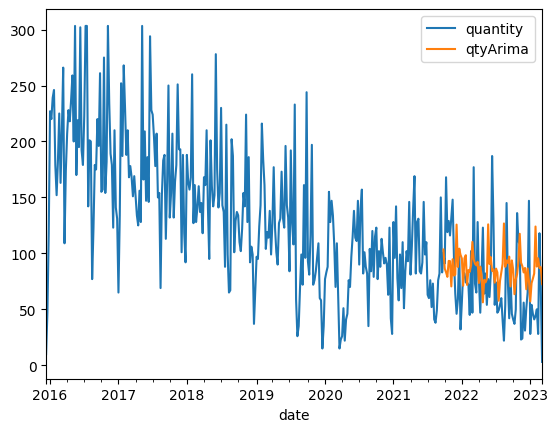

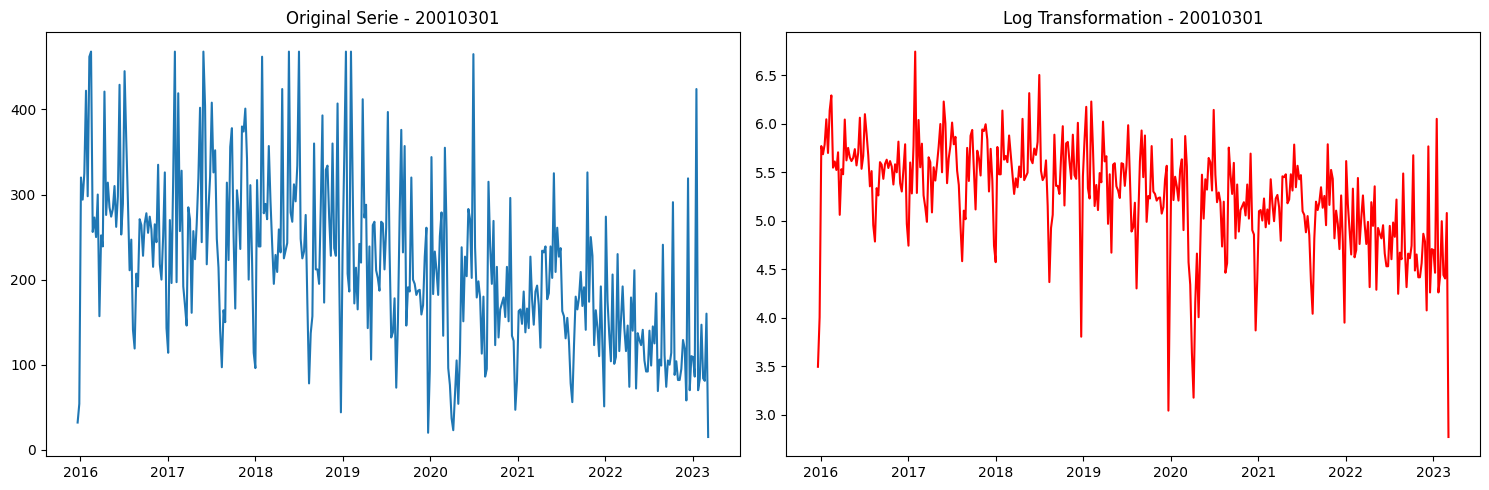

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=607.864, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=538.606, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.71 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=586.871, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=510.138, Time=0.28 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=476.126, Time=0.63 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=465.859, Time=1.14 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=463.622, Time=2.34 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=23.42 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=9.25 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=487.292, Time=2.08 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=444.289, Time=3.73 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=450.195, Time=1.75 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=29.02 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf,

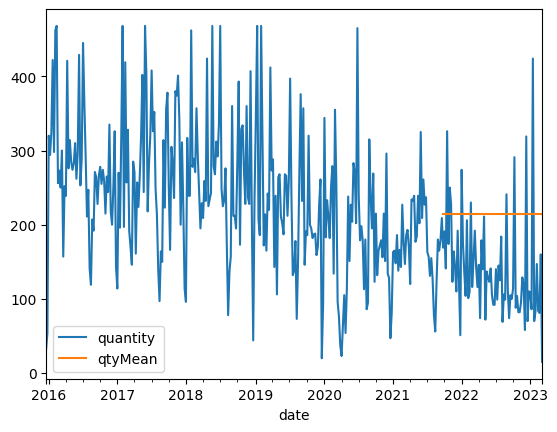

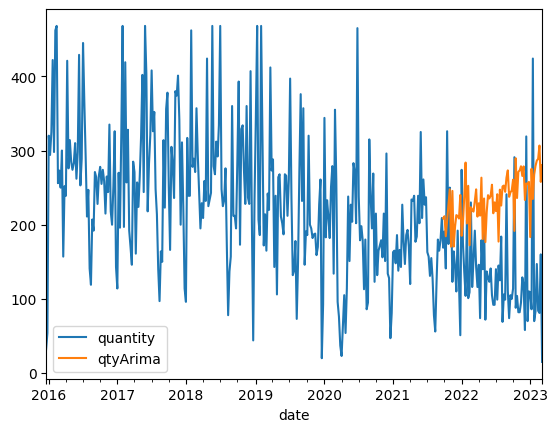

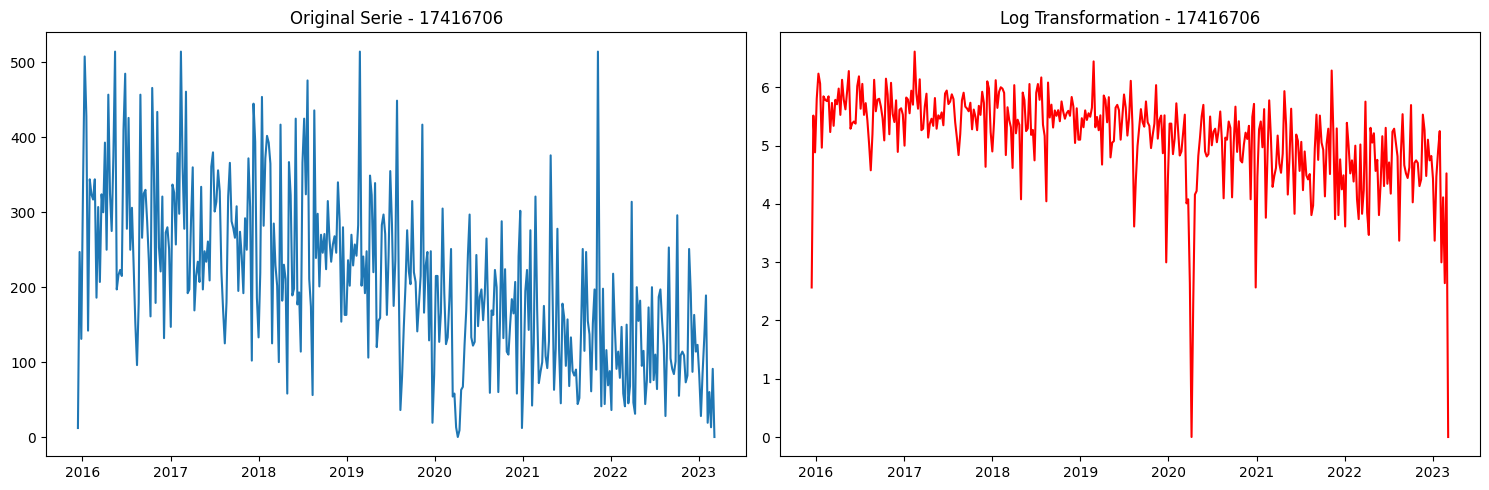

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=818.356, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=710.341, Time=0.12 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.47 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=797.298, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=691.876, Time=0.30 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=671.260, Time=0.59 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=660.991, Time=1.25 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=617.125, Time=2.79 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=616.218, Time=5.15 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=629.144, Time=3.78 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=618.208, Time=7.28 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=632.864, Time=5.86 sec
 ARIMA(0,1,0)(5,1,1)[12]             : AIC=649.316, Time=4.76 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=597.315, Time=8.20 sec
 ARIMA(2,1,0)(4,1,1)[12]             

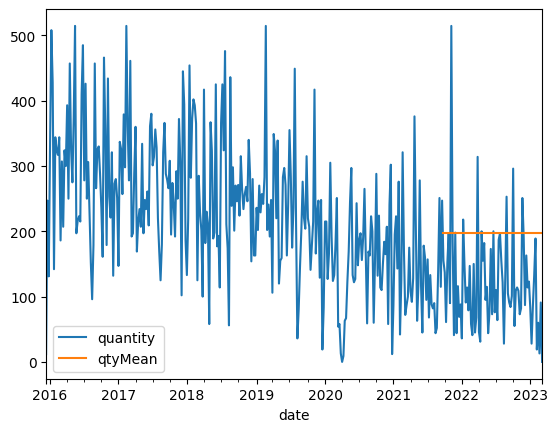

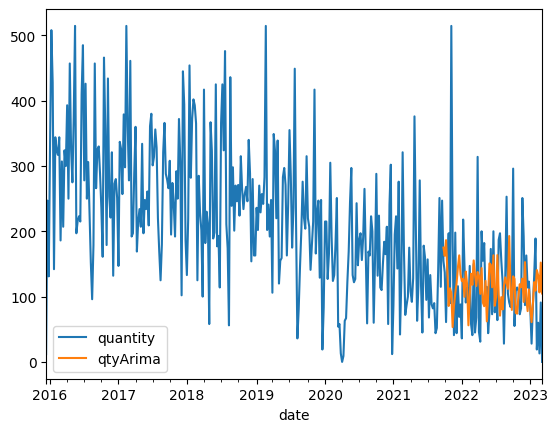

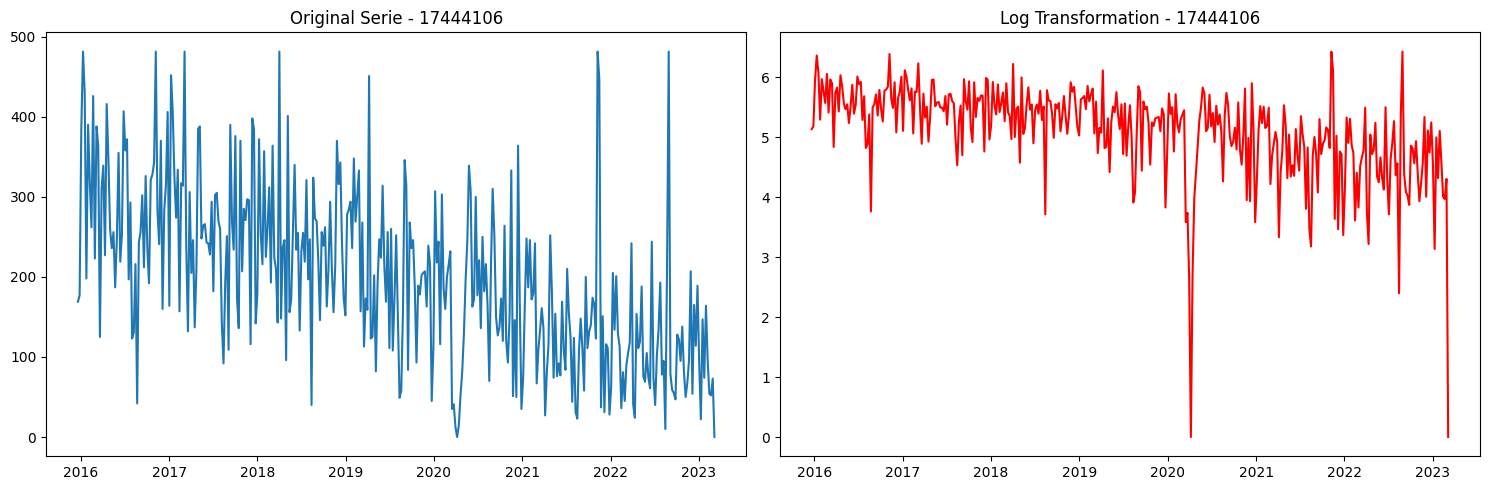

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=790.220, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=670.673, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.73 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=757.670, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=656.207, Time=0.27 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=609.451, Time=0.70 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=604.303, Time=1.30 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=601.470, Time=2.69 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=inf, Time=20.53 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=12.49 sec
 ARIMA(0,1,0)(5,1,0)[12]             : AIC=649.146, Time=1.87 sec
 ARIMA(2,1,0)(5,1,0)[12]             : AIC=586.238, Time=3.08 sec
 ARIMA(2,1,0)(4,1,0)[12]             : AIC=589.970, Time=1.54 sec
 ARIMA(2,1,0)(5,1,1)[12]             : AIC=inf, Time=18.15 sec
 ARIMA(2,1,0)(4,1,1)[12]             : AIC=inf

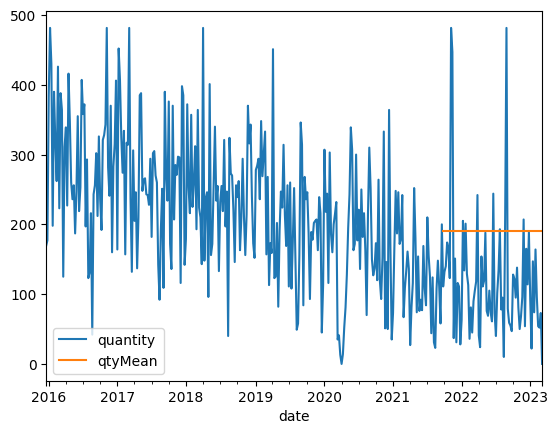

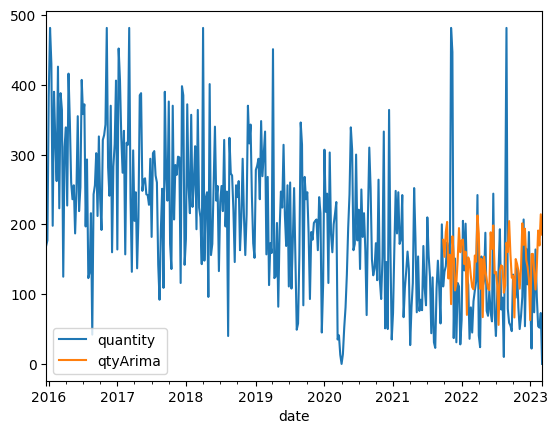

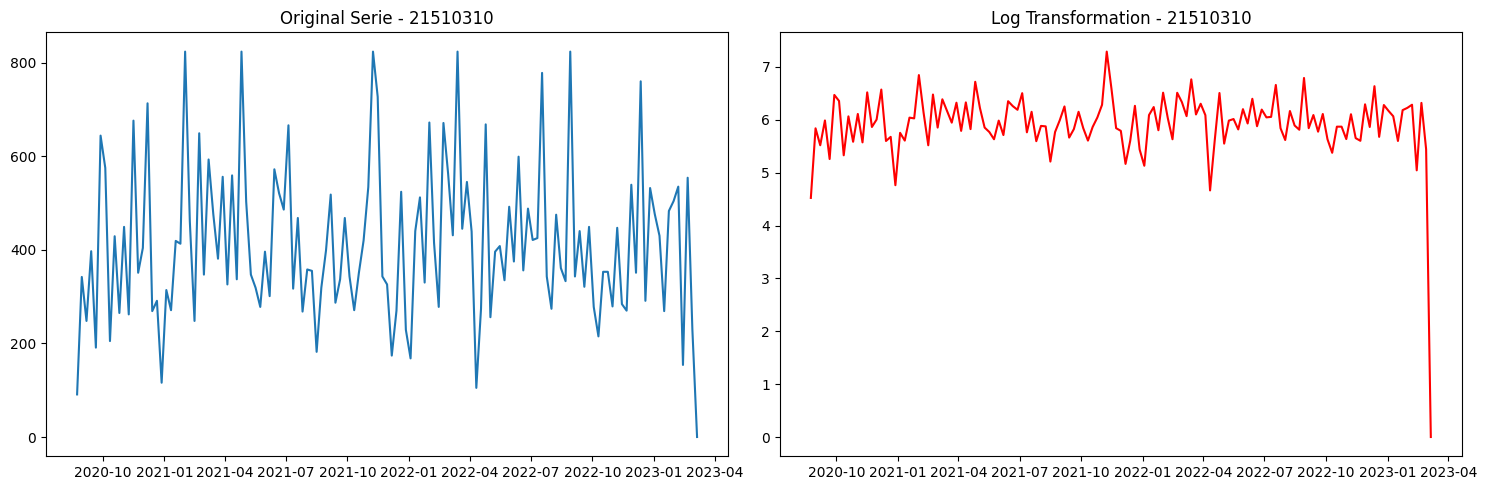

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=213.786, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=183.937, Time=0.09 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.24 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=201.318, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=181.826, Time=0.17 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=174.757, Time=0.37 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=173.261, Time=0.77 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=175.138, Time=2.40 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=175.028, Time=2.22 sec
 ARIMA(1,1,0)(3,1,1)[12]             : AIC=173.234, Time=0.82 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.96 sec
 ARIMA(1,1,0)(3,1,2)[12]             : AIC=175.040, Time=3.15 sec
 ARIMA(1,1,0)(2,1,2)[12]             : AIC=inf, Time=1.60 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=4.69 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, T

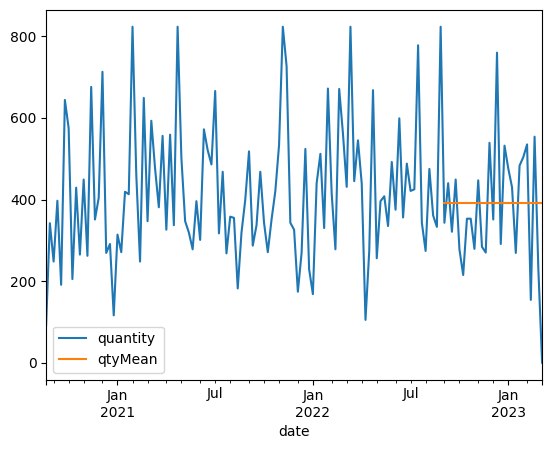

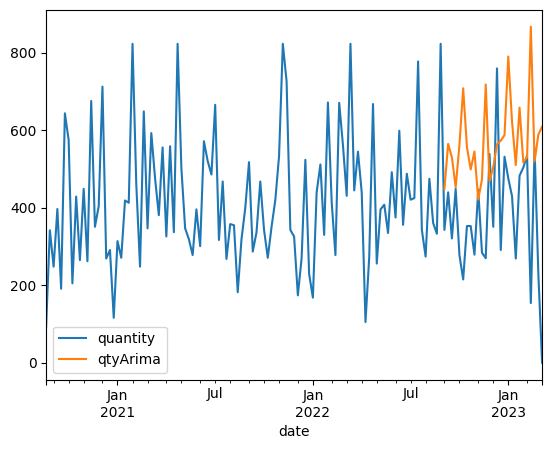

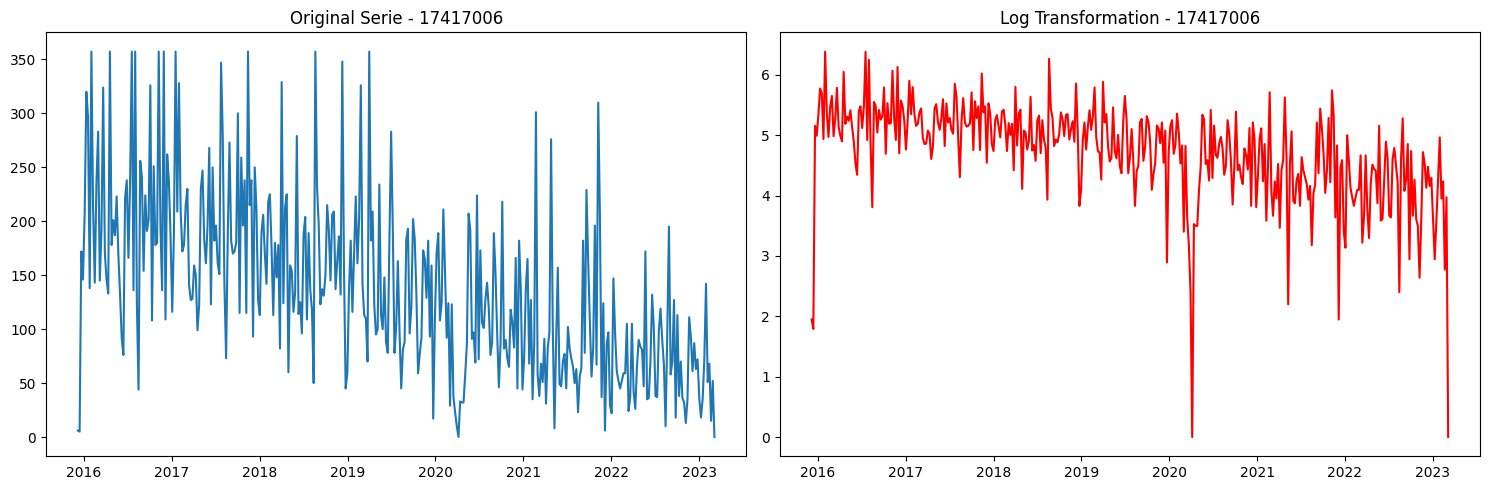

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=846.925, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=718.164, Time=0.14 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.38 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=810.549, Time=0.05 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=702.887, Time=0.29 sec
 ARIMA(1,1,0)(3,1,0)[12]             : AIC=676.955, Time=0.65 sec
 ARIMA(1,1,0)(4,1,0)[12]             : AIC=676.135, Time=1.23 sec
 ARIMA(1,1,0)(5,1,0)[12]             : AIC=653.107, Time=3.09 sec
 ARIMA(1,1,0)(5,1,1)[12]             : AIC=650.433, Time=5.43 sec
 ARIMA(1,1,0)(4,1,1)[12]             : AIC=inf, Time=5.45 sec
 ARIMA(1,1,0)(5,1,2)[12]             : AIC=652.424, Time=13.20 sec
 ARIMA(1,1,0)(4,1,2)[12]             : AIC=inf, Time=7.16 sec


KeyboardInterrupt: 

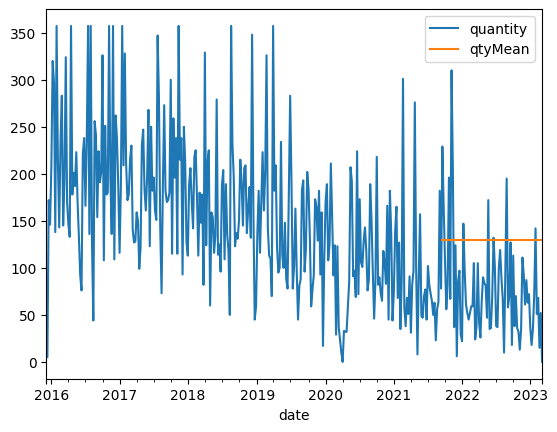

In [27]:
for item in id_list:
    one_product = sales[sales['id']==item]
    one_product = one_product.drop_duplicates()
    one_product = replace_outliers(one_product)
    ts_plot = initial_plots(one_product, item)
    split_date, train, test = split(one_product)
    one_product, test = apply_mean_model(one_product, train, test, item)
    #one_product, train, test = apply_linear_model(one_product, train, test, item)
    #one_product, train, test = apply_random_walk(one_product, train, test, item)
    #one_product, train, test = apply_moving_average(one_product, train, test, item)
    #apply_adv_xgb(one_product)
    one_product, test = apply_arima(one_product, train, test, item)
    #prophet_product, best_params = tuning_hyperparameters_prophet(one_product, train, test, item, split_date)
    #one_product, test = apply_prophet(one_product, prophet_product, best_params, train, test, item, split_date)


Include complementary info about products

In [26]:
#metrics = metrics.merge(products_info[['id','num_records', 'percentage_zero','n_zero', 'n_wk_consecutive']], how='left', on='id')

metrics

,id,model,rmse,mape,mase
0,17410306,mean,169,1.931682e+16,0.85
1,17410306,Linear model,116,9.676737e+15,0.47
2,17410306,Random Walk,209,2.228404e+16,1.09
3,17410306,Moving average,118,1.277152e+16,0.50
4,17410306,XGBoost,89,9.443890e+15,0.41
5,17410306,Arima,127,1.143123e+16,0.52
6,17410306,Prophet,169,2.089934e+16,0.84
7,20410301,mean,162,2.066936e+16,1.04
8,20410301,Linear model,100,1.410849e+16,0.56
9,20410301,Random Walk,107,1.564408e+16,0.61


In [ ]:
id_ex = '17410306'
m = sales[sales['id']== id_ex]